In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [35]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [36]:
print("train shape:", train.shape, "test shape:", test.shape)

train shape: (1460, 81) test shape: (1459, 80)


In [37]:
display(train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
display(train.describe(include='all'))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


SalePrice mean: 180921.19589041095 median: 163000.0


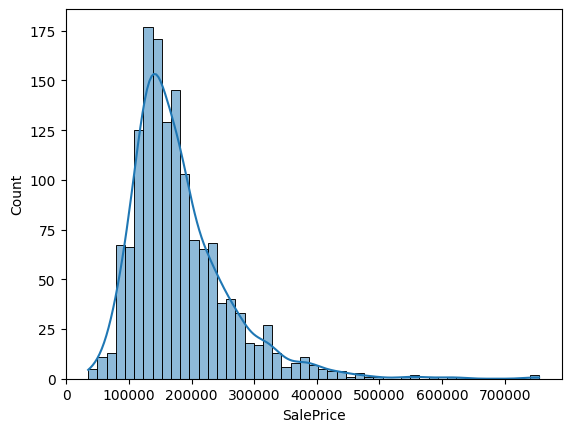

In [39]:
print("SalePrice mean:", train['SalePrice'].mean(), "median:", train['SalePrice'].median())
sns.histplot(train['SalePrice'], kde=True)
plt.show()

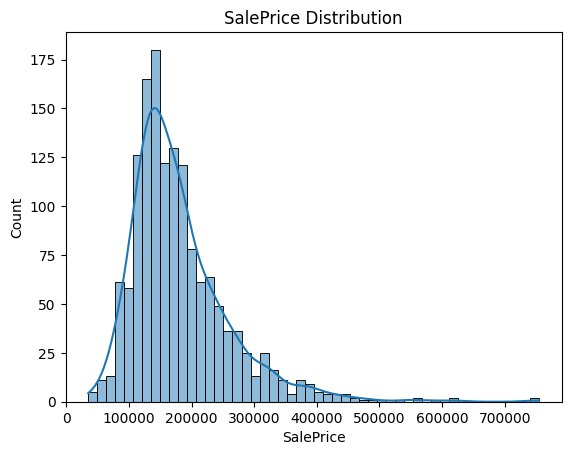

Skewness: 1.8828757597682129


In [40]:
sns.histplot(train['SalePrice'], kde=True, bins=50)
plt.title("SalePrice Distribution")
plt.show()

print("Skewness:", train['SalePrice'].skew())

#insight: because of it skewness -> use log transformation 

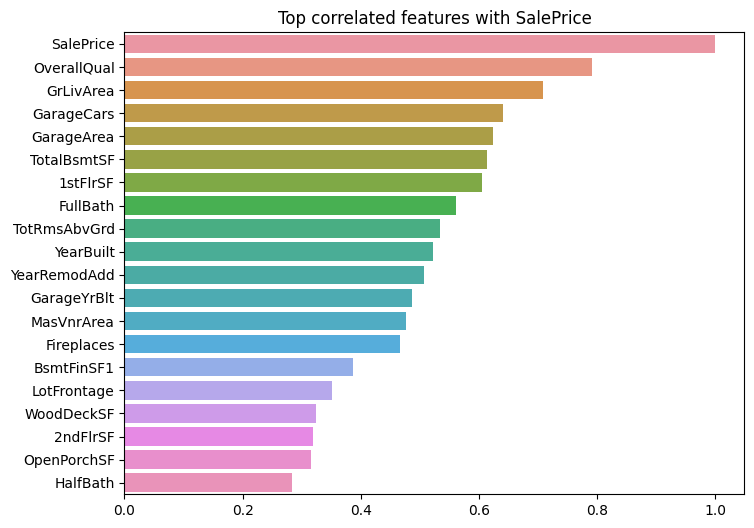

In [41]:
corr = train.corr(numeric_only=True)
top_corr = corr['SalePrice'].sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top correlated features with SalePrice")
plt.show()


# insight: too much features, so need feature selection
# few high related feature: OverallQual,GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath

In [42]:
cat_cols = train.select_dtypes(include=['object'])
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

encoded = train.copy()
for col in cat_cols:
    le = LabelEncoder()
    encoded[col] = le.fit_transform(encoded[col])

corrs = {}
for col in cat_cols:
    corrs[col] = np.corrcoef(encoded[col], train['SalePrice'])[0, 1]

sorted_corrs = sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)
for col, corr in sorted_corrs[:20]:
    print(f"{col:20s}: {corr:.4f}")

#insight: ExterQual, GarageFinish, HeatingQC. SaleCondition, Neighborhood, etc are highly related to sale

ExterQual           : -0.6369
BsmtQual            : -0.6209
KitchenQual         : -0.5892
GarageFinish        : -0.5492
FireplaceQu         : -0.4596
GarageType          : -0.4153
HeatingQC           : -0.4002
Foundation          : 0.3825
BsmtExposure        : -0.3090
MasVnrType          : -0.2816
LotShape            : -0.2556
CentralAir          : 0.2513
Electrical          : 0.2347
PavedDrive          : 0.2314
RoofStyle           : 0.2224
SaleCondition       : 0.2131
Neighborhood        : 0.2109
HouseStyle          : 0.1802
MSZoning            : -0.1669
Fence               : 0.1406


Missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


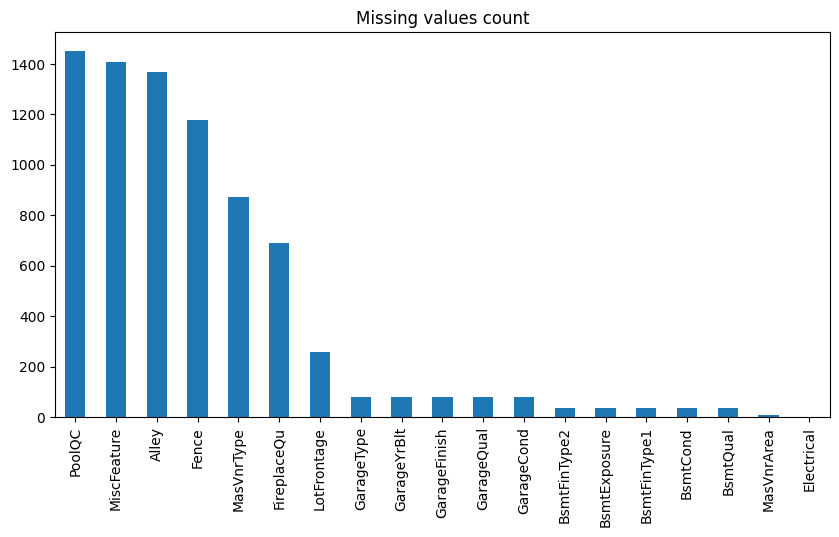

In [43]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values:")
print(missing.head(20))

plt.figure(figsize=(10,5))
missing.plot(kind='bar')
plt.title("Missing values count")
plt.show()


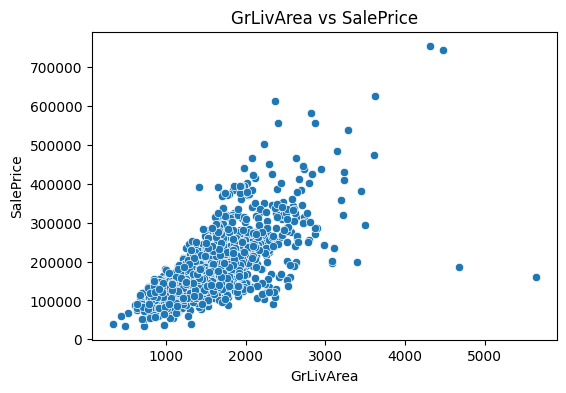

In [44]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.title("GrLivArea vs SalePrice")
plt.show()
#gridvl >4000 seems to be abnormal data

Correlation (TotalBath ~ SalePrice): 0.6317310679319879


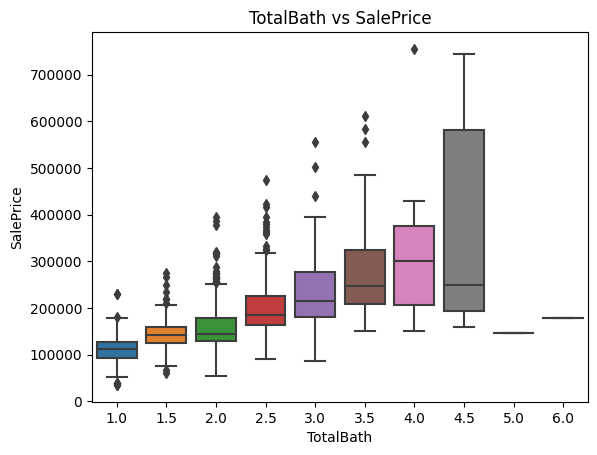

In [45]:
temp = train.copy()
temp['TotalBath'] = (
    temp['FullBath'] 
    + 0.5 * temp['HalfBath'] 
    + temp['BsmtFullBath'] 
    + 0.5 * temp['BsmtHalfBath']
)

corr_new = temp[['TotalBath','SalePrice']].corr().iloc[0,1]
print("Correlation (TotalBath ~ SalePrice):", corr_new)

sns.boxplot(x='TotalBath', y='SalePrice', data=temp)
plt.title("TotalBath vs SalePrice")
plt.show()

In [46]:
def preprocess(df):
    df = df.copy()
    
    # handle missing values
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    
    # LotFrontage：base on Neighborhood 
    if 'LotFrontage' in df.columns and 'Neighborhood' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median())
        )
    
    # numeric -> median
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    
    # cat -> 'None'
    cat_cols = df.select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].fillna('None')
    
    # new features
    
    # total SF
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # total bath
    if set(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']).issubset(df.columns):
        df['TotalBath'] = (
            df['FullBath'] + 0.5*df['HalfBath'] +
            df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
        )
    
    # total rooms
    if set(['TotRmsAbvGrd','FullBath','HalfBath']).issubset(df.columns):
        df['TotalRooms'] = df['TotRmsAbvGrd'] + df['FullBath'] + df['HalfBath']
    
    # turn sale price to log to reduce skewness
    if 'SalePrice' in df.columns:
        df['LogSalePrice'] = np.log1p(df['SalePrice'])
        df = df.drop(columns=['SalePrice'])
    
    return df


In [47]:
train_p = preprocess(train)
test_p = preprocess(test)

In [48]:
target = 'LogSalePrice'
features = [c for c in train_p.columns if c not in ['Id','LogSalePrice']]

In [49]:
X = train_p[features].copy()
y = train_p[target].copy()
X_test = test_p[features].copy()
test_ids = test_p['Id']

In [50]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [51]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


In [52]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def log_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

log_rmse_scorer = make_scorer(log_rmse, greater_is_better=False)

def rmse_cv(model, X, y):
    pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, scoring=log_rmse_scorer, cv=cv)
    return -scores.mean(), scores.std(), pipe

In [53]:
#model 1
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf_mean, rf_std, rf_pipe = rmse_cv(rf, X, y)
print(f'RandomForest CV RMSE: {rf_mean:.4f} ± {rf_std:.4f}')


RandomForest CV RMSE: 0.0110 ± 0.0013


In [54]:
#model 2
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
gb_mean, gb_std, gb_pipe = rmse_cv(gb, X, y)
print(f'GradientBoosting CV RMSE: {gb_mean:.4f} ± {gb_std:.4f}')

GradientBoosting CV RMSE: 0.0103 ± 0.0013


In [55]:
#model 3
ridge = Ridge(alpha=1.0, solver='lsqr', random_state=42)
ridge_mean, ridge_std, ridge_pipe = rmse_cv(ridge, X, y)
print(f'Ridge CV RMSE: {ridge_mean:.4f} ± {ridge_std:.4f}')

Ridge CV RMSE: 0.0113 ± 0.0023


In [56]:
#model 4
lgb_clf = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
lgb_mean, lgb_std, lgb_pipe = rmse_cv(lgb_clf, X, y)
print(f'LightGBM CV RMSE: {lgb_mean:.4f} ± {lgb_std:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3522
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 198
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3522
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 201
[LightGBM] [Info] Start training from score 12.016898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

In [57]:
lgb_pipe.fit(X, y)
gb_pipe.fit(X, y)

p_lgb = lgb_pipe.predict(X_test)
p_gb = gb_pipe.predict(X_test)

p_avg = (p_lgb + p_gb) / 2.0
y_pred = np.expm1(p_avg) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3691
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 207
[LightGBM] [Info] Start training from score 12.024057


In [58]:
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_pred
})
submission_df.to_csv('submission.csv', index=False)
print("Saved submission.csv — ready to upload to Kaggle.")
display(submission_df.head())

Saved submission.csv — ready to upload to Kaggle.


,Id,SalePrice
0,1461,123746.154111
1,1462,158437.912058
2,1463,180890.269180
3,1464,189959.708253
4,1465,188257.794800
